In [1]:
import json
import os
from pycococreatortools import pycococreatortools
import numpy as np
import cv2
import matplotlib.pyplot as plt

filename_prefix="captures_"
image_witdh = 836
image_height = 549
glock_id=2
perception_version = '0.3.0'
root_path='/home/m/weapons/dzie'
files_path=os.path.join(root_path, 'Dataset2891d5d0-e161-425f-8321-14d96ce9e8a7')
files_all = os.listdir(files_path)
files_captures = []
for filename in files_all:
    if filename.startswith(filename_prefix):
        files_captures.append(os.path.join(files_path,filename))

In [2]:
def get_color_info():
    label_id = {}
    label_color = {}
    out_color = {}
    rgb_vals = {}
    with open(os.path.join(files_path, 'annotation_definitions.json'),'r') as f:
        json_dict = json.load(f)
        for ann_def in json_dict['annotation_definitions']:
            for sp in ann_def["spec"]:
                if 'label_id' in sp and 'label_name' in sp:
                    label_id[sp['label_id']] = sp['label_name']
                if 'label_name' in sp and "pixel_value" in sp:
                    label_color[sp['label_name']] = sp['pixel_value']
        for key in label_id:
            out_color[key] = label_color[label_id[key]]
        #out color is in format {1: {'r': 0.0, 'g': 1.0, 'b': 0.0, 'a': 1.0}
        for key in out_color:
            rgb_vals[key] = np.array([int(out_color[key]['r']*255), int(out_color[key]['g']*255), int(out_color[key]['b']*255)]) 
    return rgb_vals

In [3]:
print(get_color_info())

{1: array([  0, 255,   0]), 2: array([255, 255, 255]), 3: array([127, 127, 127]), 4: array([103, 255,  81]), 5: array([255, 237,  52]), 6: array([255, 166,  16]), 7: array([255, 144,  10]), 8: array([ 16, 255,  70]), 9: array([ 47, 255,  74]), 10: array([  0,   0, 255])}


In [4]:
def annotation_from_mask(semantic_filename,x,y,width,height,image_id,annotation_id, label_id):
    x,y,width,height = [int(val) for val in [x,y,width,height]]
    annotation_filename=os.path.join(root_path, semantic_filename)
    image=cv2.imread(annotation_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotations = []
    color_info = get_color_info()
    
    full_mask = cv2.inRange(image, color_info[label_id]-2, color_info[label_id]+2)
    crop_mask = np.zeros_like(full_mask)
    crop_mask[y:y+height, x:x+width] = full_mask[y:y+height, x:x+width]
    annotation_info = pycococreatortools.create_annotation_info(
        annotation_id=annotation_id, image_id=image_id, category_info={'is_crowd':0, "id":label_id}, binary_mask=crop_mask,
        image_size=(image_witdh,image_height), tolerance=2)

    return annotation_info

In [5]:
end_json = {}
end_json['type'] = "instances"
end_json['categories'] = [{"supercategory": "weapon","id": 1,"name": "AK-74m_synth"},
                            {"supercategory": "weapon","id": 2,"name": "colt_synth"},
                            {"supercategory": "weapon","id": 3,"name": "danwesson_synth"},
                            {"supercategory": "weapon","id": 4,"name": "enfield_synth"},
                            {"supercategory": "weapon","id": 5,"name": "glock_synth"},
                            {"supercategory": "weapon","id": 6,"name": "m4_synth"},
                            {"supercategory": "weapon","id": 7,"name": "mp5_synth"},
                            {"supercategory": "weapon","id": 8,"name": "scar_synth"},
                            {"supercategory": "weapon","id": 9,"name": "thompson_synth"},
                            {"supercategory": "weapon","id": 10,"name": "ab10_synth"}]
end_json['images'], end_json["annotations"] = [],[]

In [6]:
image_id =0
annotation_id =0
for filename in files_captures:
    f = open(filename, "r")
    json_dict = json.load(f)
    for capture in json_dict['captures']:
        image_id+=1
        image_annotation = {}
        image_annotation['file_name'] = capture['filename']
        image_annotation['id'] = image_id
        image_annotation['width'] = image_witdh
        image_annotation['height'] = image_height
        image_annotation['license'] = 0
        end_json['images'].append(image_annotation)
        semantic_filename = '' 
        for annotation in capture['annotations']:
            if 'filename' in annotation.keys():
                semantic_filename = annotation['filename']
                
        for annotation in capture['annotations']:
            if 'values' in annotation.keys():
                for some_val in annotation['values']:
                    annotation_id+=1
                    x,y,width, height=some_val['x'], some_val['y'],some_val['width'],some_val['height']   
                    new_annotation = annotation_from_mask(semantic_filename, x,y,width, height,image_id, annotation_id, some_val['label_id'])
                    if new_annotation:
                        end_json["annotations"].append(new_annotation)
        

In [7]:
annotation_file=os.path.join(root_path,'trainval.json')
with open(annotation_file, 'w') as f:
    json.dump(end_json, f)

In [8]:
from pycocotools.coco import COCO
import pylab
import skimage.io as io
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

category_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(category_names)))



Custom COCO categories: 
AK-74m_synth colt_synth danwesson_synth enfield_synth glock_synth m4_synth mp5_synth scar_synth thompson_synth ab10_synth

Custom COCO supercategories: 
weapon


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


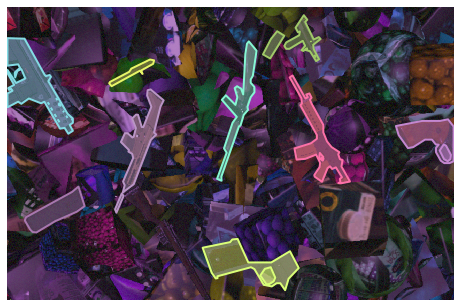

In [22]:
category_ids = coco.getCatIds()
print(category_ids)
image_ids = coco.getImgIds()
print(image_ids)
image_data = coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
image = io.imread(os.path.join(root_path,image_data['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
annotation_ids = coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = coco.loadAnns(annotation_ids)
coco.showAnns(annotations)